In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

# Load MNIST dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

# Preprocess the data
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# Normalize pixel values to the range [0, 1]
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Load Xception model (excluding top layers for feature extraction)
base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(28, 28, 3)))

# Add custom layers for classification on top of Xception base
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()
base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(28, 28, 3)))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 1, 1, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21388594 (81.59 MB)
Trainable params: 21334066 (81.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load MNIST dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

# Preprocess the data
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# Normalize pixel values to the range [0, 1]
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Repeat the single channel to mimic RGB
trainX_rgb = np.repeat(trainX, 3, axis=-1)
testX_rgb = np.repeat(testX, 3, axis=-1)

# Load Xception model (excluding top layers for feature extraction)
base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(28, 28, 3)))

# Extract features using Xception
train_features = base_model.predict(trainX_rgb)
test_features = base_model.predict(testX_rgb)

# Split the data into training and validation sets
train_features, val_features, trainY, valY = train_test_split(train_features, trainY, test_size=0.2, random_state=42)

# Build a new model with the same architecture
def build_model():
    model = Sequential()
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


313/313 [==============================] - 3s 7ms/step


In [3]:
pip install optuna

In [18]:

import optuna
# Build a new model with the same architecture
def build_model(trial):
    model = Sequential()
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Define optimizer and learning rate as hyperparameters
    optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for optimization
def objective(trial):
    model = build_model(trial)

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with EarlyStopping callback
    history = model.fit(
        train_features, trainY,
        epochs=10,  # You can adjust the number of epochs
        batch_size=32,  # You can adjust the batch size
        validation_data=(val_features, valY),
        callbacks=[early_stopping],
        verbose=0
    )

    # Get the best validation accuracy
    best_val_accuracy = max(history.history['val_accuracy'])
    return best_val_accuracy

# Optimize the hyperparameters using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best parameters
best_params = study.best_params
print("Best Hyperparameters:")
print(best_params)

# Build the final model with the best hyperparameters
final_model = build_model(optuna.trial.FixedTrial(best_params))

# Train the final model on the entire training set
final_model.fit(train_features, trainY, epochs=10, batch_size=32, verbose=2)

[I 2023-12-30 21:15:54,982] A new study created in memory with name: no-name-3483e424-043b-4a76-baa3-56f3ad8722fd
[I 2023-12-30 21:16:41,090] Trial 0 finished with value: 0.7940000295639038 and parameters: {'learning_rate': 0.007537104382859387}. Best is trial 0 with value: 0.7940000295639038.
[I 2023-12-30 21:17:28,001] Trial 1 finished with value: 0.7951666712760925 and parameters: {'learning_rate': 0.006981862662446125}. Best is trial 1 with value: 0.7951666712760925.
[I 2023-12-30 21:18:18,047] Trial 2 finished with value: 0.7684166431427002 and parameters: {'learning_rate': 0.0009178102773730138}. Best is trial 1 with value: 0.7951666712760925.
[I 2023-12-30 21:19:06,534] Trial 3 finished with value: 0.796833336353302 and parameters: {'learning_rate': 0.005028422696527429}. Best is trial 3 with value: 0.796833336353302.
[I 2023-12-30 21:19:40,849] Trial 4 finished with value: 0.7840833067893982 and parameters: {'learning_rate': 0.009022135512555754}. Best is trial 3 with value: 0.

Best Hyperparameters:
{'learning_rate': 0.005028422696527429}
Epoch 1/10
1500/1500 - 4s - loss: 0.8953 - accuracy: 0.7015 - 4s/epoch - 3ms/step
Epoch 2/10
1500/1500 - 3s - loss: 0.7043 - accuracy: 0.7602 - 3s/epoch - 2ms/step
Epoch 3/10
1500/1500 - 4s - loss: 0.6544 - accuracy: 0.7761 - 4s/epoch - 3ms/step
Epoch 4/10
1500/1500 - 3s - loss: 0.6179 - accuracy: 0.7870 - 3s/epoch - 2ms/step
Epoch 5/10
1500/1500 - 3s - loss: 0.5858 - accuracy: 0.7974 - 3s/epoch - 2ms/step
Epoch 6/10
1500/1500 - 3s - loss: 0.5663 - accuracy: 0.8044 - 3s/epoch - 2ms/step
Epoch 7/10
1500/1500 - 4s - loss: 0.5523 - accuracy: 0.8099 - 4s/epoch - 3ms/step
Epoch 8/10
1500/1500 - 3s - loss: 0.5300 - accuracy: 0.8164 - 3s/epoch - 2ms/step
Epoch 9/10
1500/1500 - 3s - loss: 0.5223 - accuracy: 0.8190 - 3s/epoch - 2ms/step
Epoch 10/10
1500/1500 - 4s - loss: 0.5144 - accuracy: 0.8227 - 4s/epoch - 3ms/step


In [19]:

from sklearn.metrics import accuracy_score

# Transform features for SVM
train_features_svm = train_features.reshape((train_features.shape[0], -1))
val_features_svm = val_features.reshape((val_features.shape[0], -1))
test_features_svm = test_features.reshape((test_features.shape[0], -1))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train Random Forest Classifier
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_features_svm, np.argmax(trainY, axis=1))

# Predict using Random Forest
val_predictions_rf = random_forest_classifier.predict(val_features_svm)
test_predictions_rf = random_forest_classifier.predict(test_features_svm)

# Evaluate Random Forest accuracy
val_accuracy_rf = accuracy_score(np.argmax(valY, axis=1), val_predictions_rf)
test_accuracy_rf = accuracy_score(np.argmax(testY, axis=1), test_predictions_rf)

print(f"Validation Accuracy (Random Forest): {val_accuracy_rf}")
print(f"Test Accuracy (Random Forest): {test_accuracy_rf}")


Validation Accuracy (Random Forest): 0.7531666666666667
Test Accuracy (Random Forest): 0.7554


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

# Predict using the final model or the chosen classifier
test_predictions_final = random_forest_classifier.predict(test_features_svm)  # Replace with your classifier

# Convert one-hot encoded labels back to integer labels
true_labels = np.argmax(testY, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, test_predictions_final, average='weighted')
recall = recall_score(true_labels, test_predictions_final, average='weighted')
f1 = f1_score(true_labels, test_predictions_final, average='weighted')

# Print precision, recall, and F1 score
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, test_predictions_final)





Precision: 0.7632
Recall: 0.7554
F1 Score: 0.7579


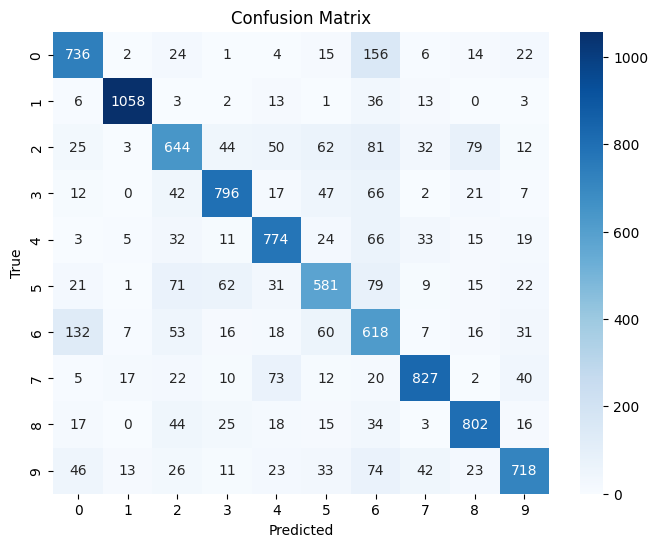

In [23]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()